<a href="https://colab.research.google.com/github/EmaIT28/PPPO_Klasifikacija/blob/main/Ema_Kuzmanovic_IT_28_2019_Klasifikacija.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predmet: Principi prezentacije i prepoznavanje oblika**

**Tema: Klasifikacija**

**Student:Ema Kuzmanović IT-28/2019**


**Klasifikacija**

Klasifikacija je postupak predviđanja/određivanja klase datih tačaka podataka korišćenjem postejećeg označavanja tačaka. Klasifikacija se ubraja u kategoriju nadgledanog mašinskog učenja. U okviru mašinskog učenja, konkretno za uspešnost zadataka klasifikacije, ulazni set podataka mora biti obiman i raznovrstan.

---



Dataset sadrži slike pasa raspoređenih u dva foldera, folder "train" i folder "test", kao i dva csv fajla, "labels" i "sample_submissions" u prvom se nalaze definisane slike(id) i rasu pasa(breed), dok drugi sadrži željeni krajnji izlaz programa.



**Importi**

Definisanje neophodnih biblioteka

In [ ]:
import zipfile
zip_path = r"C:\Users\Ema\Desktop\FAKS\CETVRTA GOD\prepoznavanje oblika\Dog_Classification.zip"
extract_path = r"D:\Dogs"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import numpy as np
import pandas as pd
import os, cv2, random, time, shutil, csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gc
from tqdm import tqdm


import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

Definicija funkcije koja broji sve fajlove u folderu

In [ ]:
def get_num_files(path):
    if not os.path.exists(path):
        return 0
    return sum([len(files) for r, d, files in os.walk(path)])

Učitavanje direktorijuma sa podacima:

In [ ]:
train_dir = 'D:/Dogs/train'
test_dir = 'D:/Dogs/test'

data_size = get_num_files(train_dir)
test_size = get_num_files(test_dir)
print('Data samples size: ', data_size)
print('Test samples size: ', test_size)

Data samples size:  10222
Test samples size:  10357


In [ ]:
labels_dataframe = pd.read_csv('D:/Dogs/labels.csv')

sample_df = pd.read_csv('D:/Dogs/sample_submission.csv')

labels_dataframe.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


Prikaz jedne fotografije:

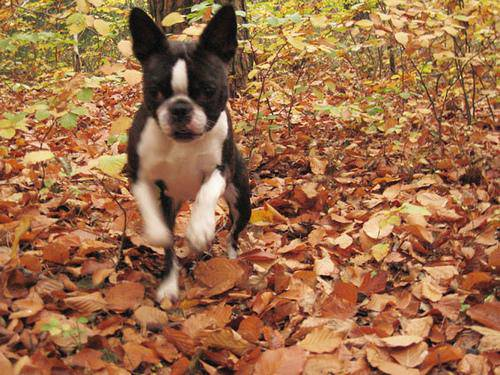

In [ ]:
from IPython.display import Image

path = "D:/Dogs/train/000bec180eb18c7604dcecc8fe0dba07.jpg"
Image(filename=path)

Sortiranje liste sa rasama i prikaz prvih 10

In [ ]:
dog_breeds = sorted(list(set(labels_dataframe['breed'])))
n_classes = len(dog_breeds)
print(n_classes)
dog_breeds[:10]

120


['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle']

rečnik pojmova:

In [ ]:
class_to_num = dict(zip(dog_breeds, range(n_classes)))

Smeštanje slika u niz:

In [ ]:
def images_to_array(data_dir, labels_dataframe, img_size = (224,224,3)):

  images_names = labels_dataframe['id']
  images_labels = labels_dataframe['breed']
  data_size = len(images_names)
  #initailize output arrays
  X = np.zeros([data_size, img_size[0], img_size[1], img_size[2]], dtype = np.uint8)
  Y = np.zeros([data_size,1], dtype = np.uint8)
  #read data and labels
  for i in tqdm(range(data_size)):
    image_name = images_names[i]
    img_dir = os.path.join(data_dir, image_name + '.jpg')
    img_pixels = load_img(img_dir, target_size = img_size)
    X[i] = img_pixels

    image_breed = images_labels[i]
    Y[i] = class_to_num[image_breed]


  Y = to_categorical(Y)
  #shuffle
  ind = np.random.permutation(data_size)
  X = X[ind]
  Y = Y[ind]
  print('Output data size: ', X.shape)
  print('Output label size: ', Y.shape)
  return X, Y
  gc.collect()

Definisanje rezolucije fotografija:

In [ ]:
img_size = (250,250,3)
X, Y = images_to_array(train_dir, labels_dataframe, img_size)

100%|████████████████████████████████████████████████████████████████████████████| 10222/10222 [02:11<00:00, 77.88it/s]


Output data size:  (10222, 250, 250, 3)
Output label size:  (10222, 120)


Definisanje get_features funkcije:

In [ ]:
def get_features(model_name, data_preprocessor, input_size, data):

    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    #Extract feature.
    feature_maps = feature_extractor.predict(data, batch_size=64, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps
    gc.collect()

CNN

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

160/160 [==============================] - 460s 3s/step
Feature maps shape:  (10222, 2048)


In [ ]:
final_features = inception_features
print('Final feature maps shape', final_features.shape)

Final feature maps shape (10222, 2048)


EarlyStopping callback

In [ ]:
from keras.callbacks import EarlyStopping
#Prepare call backs
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callback=[EarlyStop_callback]

**Best case**


In [ ]:
gc.collect()
#Prepare DNN model
dnn = keras.models.Sequential([
    InputLayer(final_features.shape[1:]),
    Dropout(0.7),
    Dense(n_classes, activation='softmax')
])

dnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Train simple DNN on extracted features.
h = dnn.fit(final_features, Y,
            batch_size=128,
            epochs=60,
            validation_split=0.1,
            callbacks=EarlyStop_callback)
gc.collect()

Epoch 1/60
72/72 [==============================] - 1s 9ms/step - loss: 2.6102 - accuracy: 0.4316 - val_loss: 0.6956 - val_accuracy: 0.8172
Epoch 2/60
72/72 [==============================] - 0s 6ms/step - loss: 0.8236 - accuracy: 0.7661 - val_loss: 0.5740 - val_accuracy: 0.8328
Epoch 3/60
72/72 [==============================] - 0s 6ms/step - loss: 0.6434 - accuracy: 0.8047 - val_loss: 0.5635 - val_accuracy: 0.8338
Epoch 4/60
72/72 [==============================] - 0s 6ms/step - loss: 0.5616 - accuracy: 0.8272 - val_loss: 0.5542 - val_accuracy: 0.8358
Epoch 5/60
72/72 [==============================] - 0s 6ms/step - loss: 0.5021 - accuracy: 0.8420 - val_loss: 0.5575 - val_accuracy: 0.8348
Epoch 6/60
72/72 [==============================] - 0s 6ms/step - loss: 0.4634 - accuracy: 0.8526 - val_loss: 0.5737 - val_accuracy: 0.8240
Epoch 7/60
72/72 [==============================] - 0s 6ms/step - loss: 0.4187 - accuracy: 0.8663 - val_loss: 0.5719 - val_accuracy: 0.8319
Epoch 8/60
72/72 [==

1539

Prikaz tačnosti istreniranog modela:

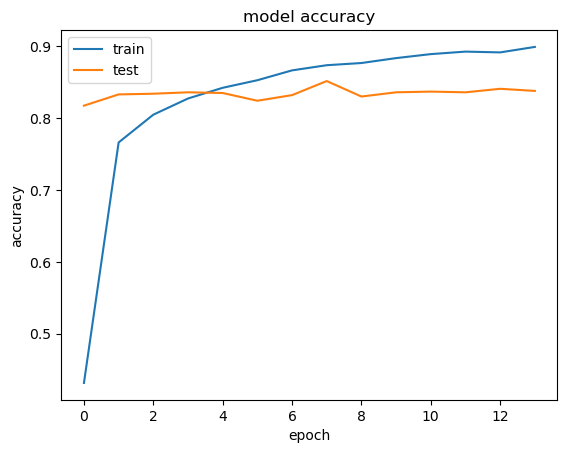

3288

In [ ]:
keras.backend.clear_session()
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
gc.collect()

Ponovno ubacivanje slika u niz i druga funkcija za testiranje podataka:

In [ ]:
gc.collect()
def images_to_array2(data_dir, labels_dataframe, img_size = (224,224,3)):

    images_names = labels_dataframe['id']
    data_size = len(images_names)
    X = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)

    for i in tqdm(range(data_size)):
        image_name = images_names[i]
        img_dir = os.path.join(data_dir, image_name+'.jpg')
        img_pixels = tf.keras.preprocessing.image.load_img(img_dir, target_size=img_size)
        X[i] = img_pixels

    print('Ouptut data size: ', X.shape)
    return X

test_data = images_to_array2(test_dir, sample_df, img_size)

100%|████████████████████████████████████████████████████████████████████████████| 10357/10357 [02:09<00:00, 80.00it/s]

Ouptut data size:  (10357, 250, 250, 3)


In [ ]:
#Extract test data features
inception_features = get_features(InceptionV3, inception_preprocessor, img_size, test_data)

test_features = inception_features
print('Final feature maps shape', test_features.shape)

162/162 [==============================] - 459s 3s/step
Feature maps shape:  (10357, 2048)
Final feature maps shape (10357, 2048)


In [ ]:
y_pred = dnn.predict(test_features, batch_size=128)

81/81 [==============================] - 0s 2ms/step


Pisanje rezultata u novi fajl:

In [ ]:
for b in dog_breeds:
    sample_df[b] = y_pred[:,class_to_num[b]]
sample_df.to_csv('C:/Users/Ema/Desktop/FAKS/CETVRTA GOD/prepoznavanje oblika/Rezultati.txt', index=None)

**Literatura**

Keras - https://keras.io/api/applications/inceptionv3/

Papers with code: https://paperswithcode.com/method/inception-v3

Nepreciznost i linarne klasifikacija - https://medium.com/mindorks/classification-problems-with-tensorflow-27eab36aa037

Adam - https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/




**Zaključak**

Sama izrada projekta je bila veoma interesantna i tokom izrade sam stekla uvid koliko je oblast dubokog učenja kompleksna.